# NYC Crash Risk Prediction - Exploratory Data Analysis

Comprehensive analysis of the NYC vehicle collision dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

## 1. Data Loading

In [2]:
# Load processed dataset (sample for EDA)
SAMPLE_SIZE = 100_000

df = pd.read_csv('../data/processed/train.csv', parse_dates=['hour'])
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)

print(f"Total records: {len(df):,}")
print(f"Sample size: {len(df_sample):,}")
print(f"Date range: {df['hour'].min()} to {df['hour'].max()}")
print(f"Unique hexagons: {df['h3_index'].nunique():,}")

Total records: 3,200,692
Sample size: 100,000
Date range: 2012-07-01 00:00:00 to 2023-03-28 09:00:00
Unique hexagons: 34


In [3]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 2800021 to 675966
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   h3_index           100000 non-null  object        
 1   hour               100000 non-null  datetime64[ns]
 2   accident_count     100000 non-null  int64         
 3   total_injured      100000 non-null  int64         
 4   temperature        100000 non-null  float64       
 5   precipitation      100000 non-null  float64       
 6   wind_speed         100000 non-null  float64       
 7   snow_depth         100000 non-null  float64       
 8   is_holiday         100000 non-null  bool          
 9   hour_of_day        100000 non-null  int64         
 10  day_of_week        100000 non-null  int64         
 11  month              100000 non-null  int64         
 12  year               100000 non-null  int64         
 13  is_weekend         100000 non-null  bool   

In [4]:
df_sample.describe()

,hour,accident_count,total_injured,temperature,precipitation,wind_speed,snow_depth,hour_of_day,day_of_week,month,year,accidents_1h_ago,accidents_24h_ago,rolling_mean_7d
count,100000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000
mean,2017-11-14 15:57:05.400000,0.1849,0.0547,13.5063,0.1579,15.1712,0.0000,11.4894,3.0004,6.5712,2017.3669,0.1844,0.1805,0.1843
min,2012-07-01 00:00:00,0.0000,0.0000,-17.2000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2012.0000,0.0000,0.0000,0.0000
25%,2015-03-12 02:00:00,0.0000,0.0000,5.0000,0.0000,9.4000,0.0000,6.0000,1.0000,3.0000,2015.0000,0.0000,0.0000,0.0774
50%,2017-11-15 08:30:00,0.0000,0.0000,13.9000,0.0000,14.8000,0.0000,11.0000,3.0000,7.0000,2017.0000,0.0000,0.0000,0.1488
75%,2020-07-19 06:30:00,0.0000,0.0000,22.2000,0.0000,20.5000,0.0000,17.0000,5.0000,10.0000,2020.0000,0.0000,0.0000,0.2381
max,2023-03-28 08:00:00,7.0000,10.0000,39.4000,45.5000,74.2000,0.0000,23.0000,6.0000,12.0000,2023.0000,7.0000,7.0000,1.2976
std,NaN,0.4797,0.3184,10.2725,0.9689,8.7867,0.0000,6.9110,1.9992,3.4793,3.1163,0.4808,0.4744,0.1620


## 2. Target Variable Analysis

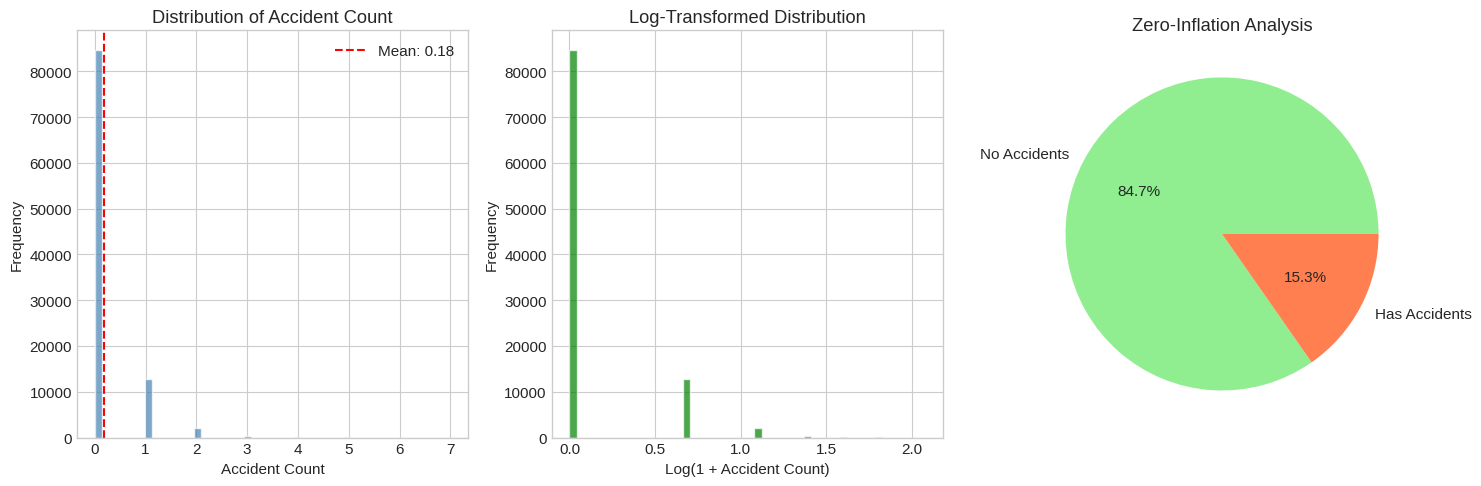

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Distribution
axes[0].hist(df_sample['accident_count'], bins=50, alpha=0.7, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Accident Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Accident Count')
axes[0].axvline(df_sample['accident_count'].mean(), color='red', linestyle='--', label=f"Mean: {df_sample['accident_count'].mean():.2f}")
axes[0].legend()

# Log distribution
log_counts = np.log1p(df_sample['accident_count'])
axes[1].hist(log_counts, bins=50, alpha=0.7, color='green', edgecolor='white')
axes[1].set_xlabel('Log(1 + Accident Count)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Distribution')

# Zero vs non-zero
zero_pct = (df_sample['accident_count'] == 0).mean() * 100
axes[2].pie([zero_pct, 100-zero_pct], labels=['No Accidents', 'Has Accidents'], 
            autopct='%1.1f%%', colors=['lightgreen', 'coral'])
axes[2].set_title('Zero-Inflation Analysis')

plt.tight_layout()
plt.savefig('../data/processed/eda_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
print("Target Variable Statistics:")
print(f"  Mean: {df_sample['accident_count'].mean():.4f}")
print(f"  Median: {df_sample['accident_count'].median():.4f}")
print(f"  Std: {df_sample['accident_count'].std():.4f}")
print(f"  Max: {df_sample['accident_count'].max():.0f}")
print(f"  Zero-inflation: {(df_sample['accident_count'] == 0).mean()*100:.2f}%")
print(f"  Skewness: {df_sample['accident_count'].skew():.4f}")
print(f"  Kurtosis: {df_sample['accident_count'].kurtosis():.4f}")

Target Variable Statistics:
  Mean: 0.1849
  Median: 0.0000
  Std: 0.4797
  Max: 7
  Zero-inflation: 84.69%
  Skewness: 3.1602
  Kurtosis: 13.0773


## 3. Temporal Patterns

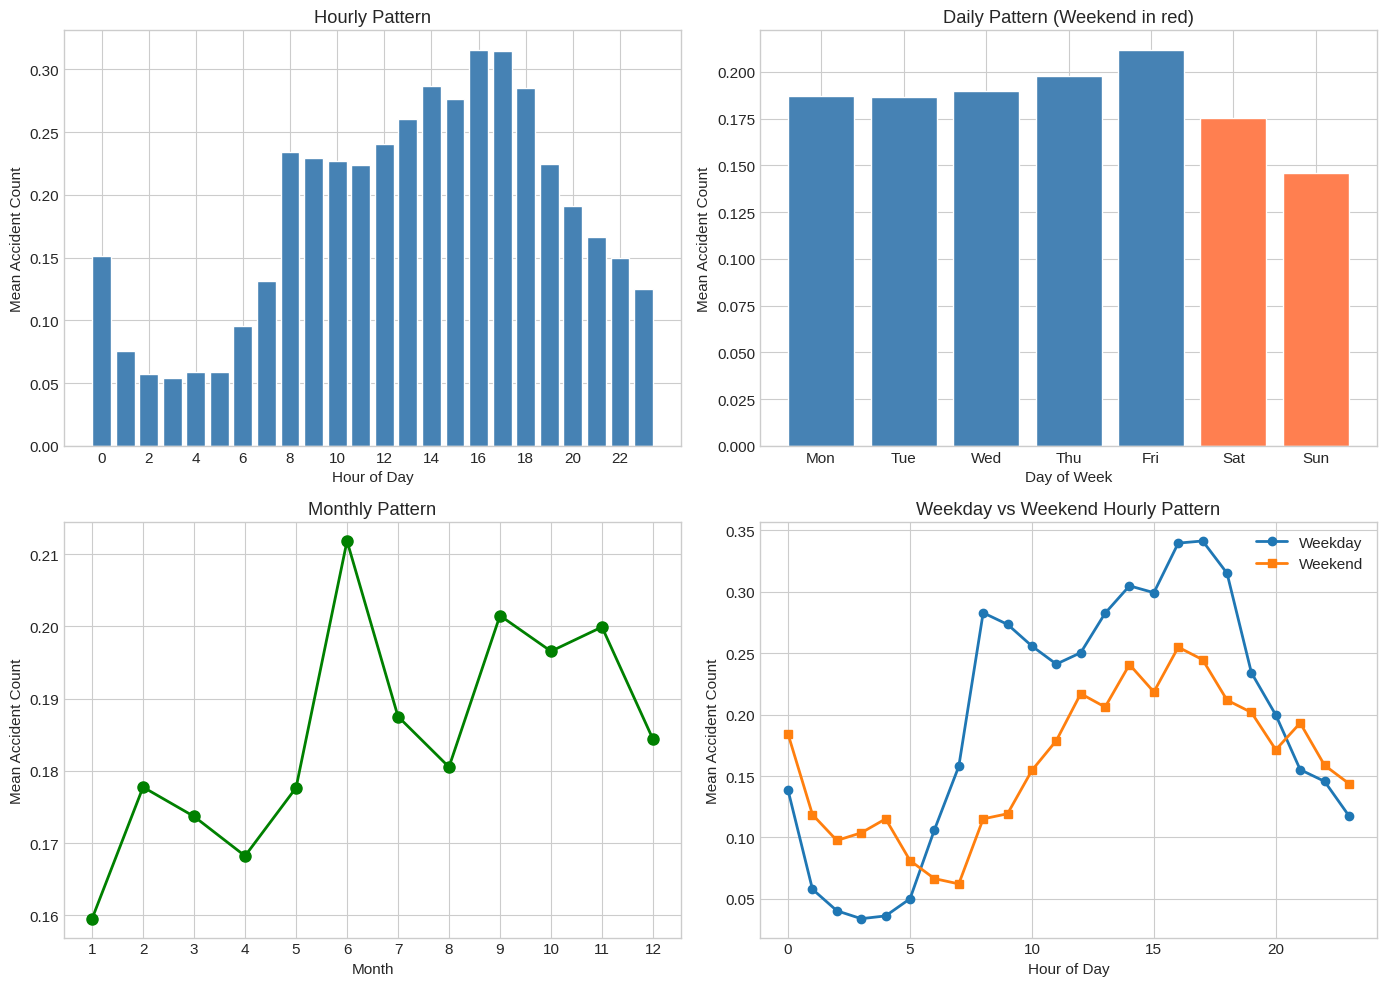

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hourly pattern
hourly = df_sample.groupby('hour_of_day')['accident_count'].mean()
axes[0, 0].bar(hourly.index, hourly.values, color='steelblue', edgecolor='white')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Mean Accident Count')
axes[0, 0].set_title('Hourly Pattern')
axes[0, 0].set_xticks(range(0, 24, 2))

# Daily pattern
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily = df_sample.groupby('day_of_week')['accident_count'].mean()
colors = ['steelblue']*5 + ['coral']*2
axes[0, 1].bar(day_names, daily.values, color=colors, edgecolor='white')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Mean Accident Count')
axes[0, 1].set_title('Daily Pattern (Weekend in red)')

# Monthly pattern
monthly = df_sample.groupby('month')['accident_count'].mean()
axes[1, 0].plot(monthly.index, monthly.values, 'o-', color='green', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Mean Accident Count')
axes[1, 0].set_title('Monthly Pattern')
axes[1, 0].set_xticks(range(1, 13))

# Weekend vs Weekday
grouping = df_sample.groupby(['hour_of_day', 'is_weekend'])['accident_count'].mean().unstack()
grouping.columns = ['Weekday', 'Weekend']
grouping.plot(ax=axes[1, 1], style=['o-', 's-'], linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Mean Accident Count')
axes[1, 1].set_title('Weekday vs Weekend Hourly Pattern')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../data/processed/eda_temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Weather Impact Analysis

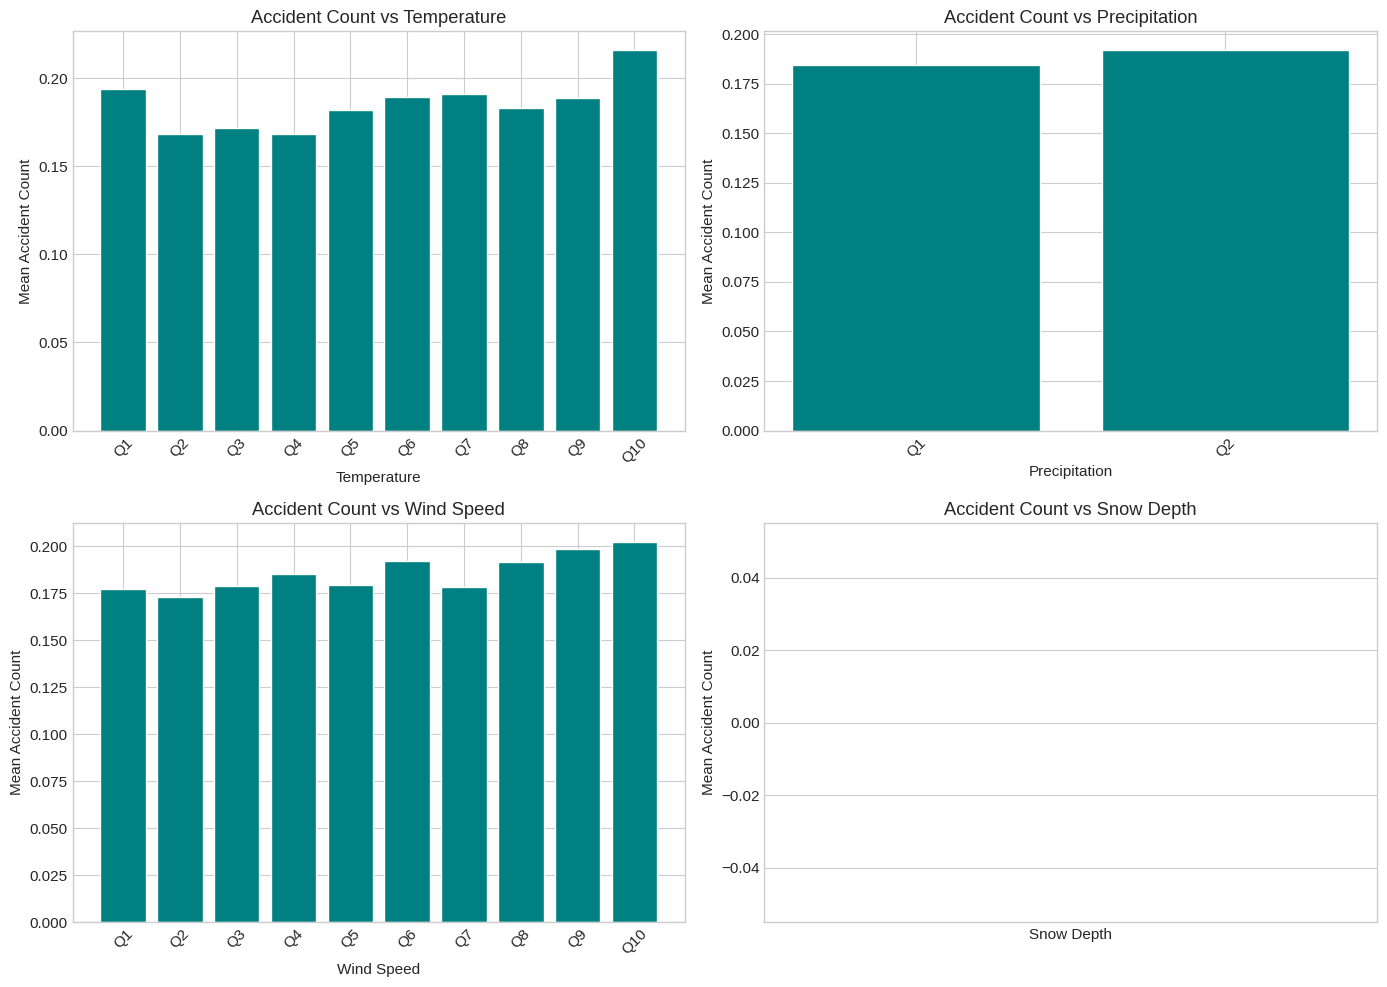

In [8]:
weather_cols = ['temperature', 'precipitation', 'wind_speed', 'snow_depth']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, col in enumerate(weather_cols):
    ax = axes[idx // 2, idx % 2]
    
    # Bin the weather variable
    df_sample[f'{col}_bin'] = pd.qcut(df_sample[col], q=10, duplicates='drop')
    grouped = df_sample.groupby(f'{col}_bin')['accident_count'].mean()
    
    ax.bar(range(len(grouped)), grouped.values, color='teal', edgecolor='white')
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Mean Accident Count')
    ax.set_title(f'Accident Count vs {col.replace("_", " ").title()}')
    ax.set_xticks(range(len(grouped)))
    ax.set_xticklabels([f'Q{i+1}' for i in range(len(grouped))], rotation=45)

plt.tight_layout()
plt.savefig('../data/processed/eda_weather_impact.png', dpi=150, bbox_inches='tight')
plt.show()

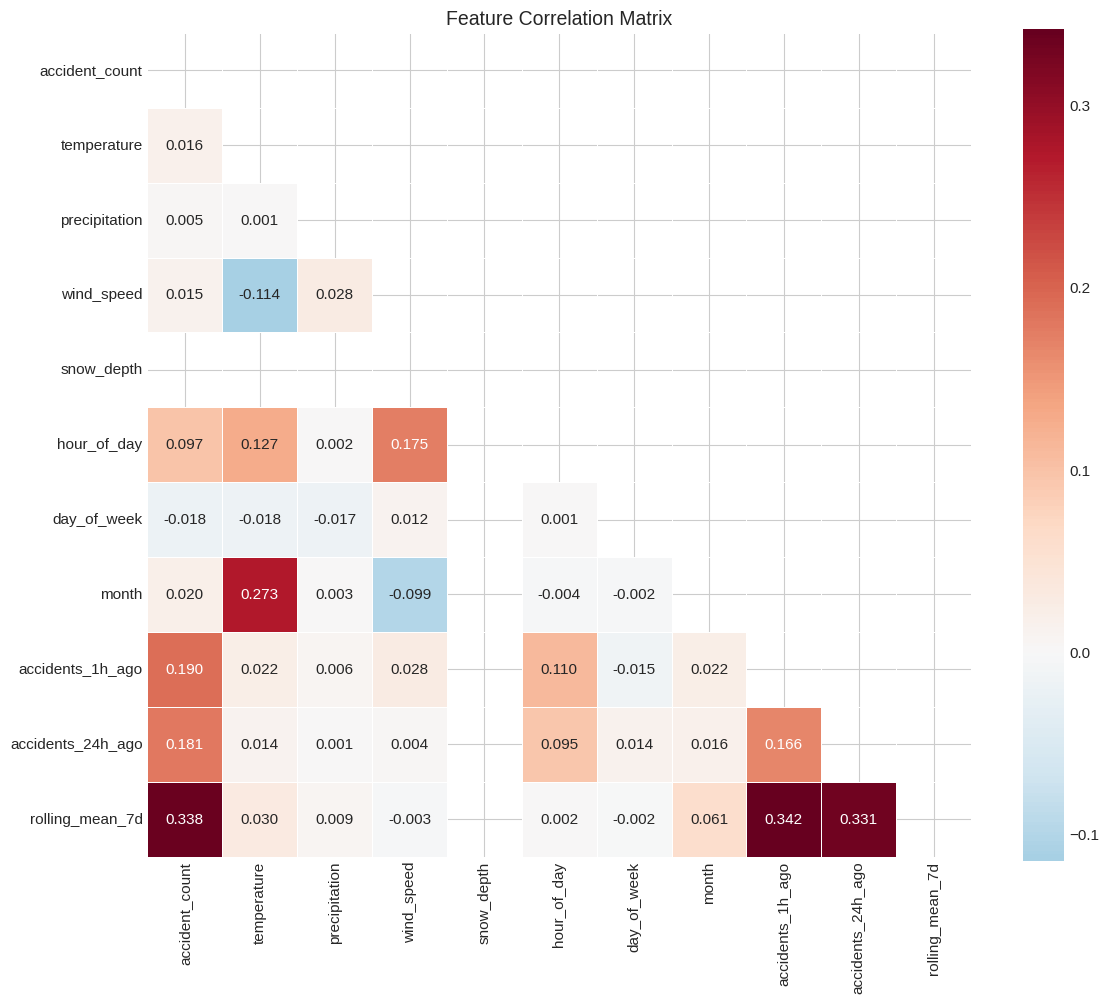

In [9]:
# Correlation analysis
corr_cols = ['accident_count', 'temperature', 'precipitation', 'wind_speed', 
             'snow_depth', 'hour_of_day', 'day_of_week', 'month',
             'accidents_1h_ago', 'accidents_24h_ago', 'rolling_mean_7d']

corr_matrix = df_sample[corr_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('../data/processed/eda_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Spatial Analysis

In [10]:
# Hexagon-level statistics
hex_stats = df.groupby('h3_index').agg({
    'accident_count': ['mean', 'std', 'sum', 'count']
}).reset_index()
hex_stats.columns = ['h3_index', 'mean_accidents', 'std_accidents', 'total_accidents', 'n_records']

print(f"Hexagon Statistics:")
print(f"  Total hexagons: {len(hex_stats):,}")
print(f"  Mean accidents per hexagon: {hex_stats['mean_accidents'].mean():.4f}")
print(f"  Std accidents per hexagon: {hex_stats['mean_accidents'].std():.4f}")
print(f"  Top 10 hotspots account for: {hex_stats.nlargest(10, 'total_accidents')['total_accidents'].sum() / hex_stats['total_accidents'].sum() * 100:.1f}% of accidents")

Hexagon Statistics:
  Total hexagons: 34
  Mean accidents per hexagon: 0.1838
  Std accidents per hexagon: 0.1344
  Top 10 hotspots account for: 54.7% of accidents


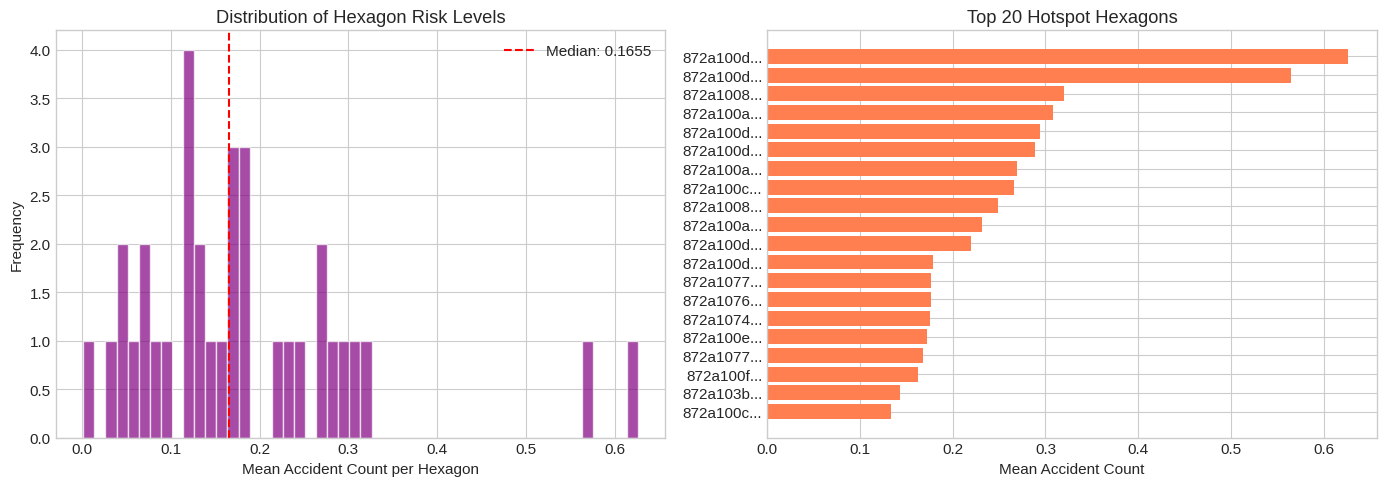

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of hexagon average accidents
axes[0].hist(hex_stats['mean_accidents'], bins=50, alpha=0.7, color='purple', edgecolor='white')
axes[0].set_xlabel('Mean Accident Count per Hexagon')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Hexagon Risk Levels')
axes[0].axvline(hex_stats['mean_accidents'].median(), color='red', linestyle='--', 
                label=f"Median: {hex_stats['mean_accidents'].median():.4f}")
axes[0].legend()

# Top 20 hotspots
top_20 = hex_stats.nlargest(20, 'mean_accidents')
axes[1].barh(range(20), top_20['mean_accidents'].values, color='coral')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels([f"{h[:8]}..." for h in top_20['h3_index']])
axes[1].set_xlabel('Mean Accident Count')
axes[1].set_title('Top 20 Hotspot Hexagons')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../data/processed/eda_spatial_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Lag Features Analysis

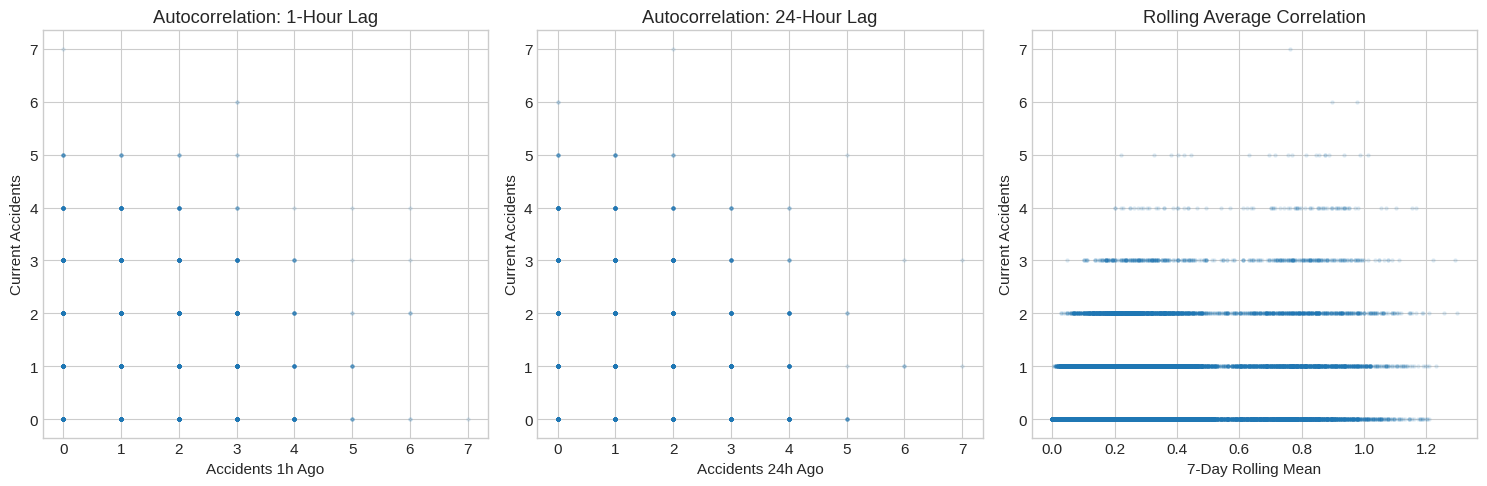

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accidents 1h ago vs current
axes[0].scatter(df_sample['accidents_1h_ago'], df_sample['accident_count'], alpha=0.1, s=5)
axes[0].set_xlabel('Accidents 1h Ago')
axes[0].set_ylabel('Current Accidents')
axes[0].set_title('Autocorrelation: 1-Hour Lag')

# Accidents 24h ago vs current
axes[1].scatter(df_sample['accidents_24h_ago'], df_sample['accident_count'], alpha=0.1, s=5)
axes[1].set_xlabel('Accidents 24h Ago')
axes[1].set_ylabel('Current Accidents')
axes[1].set_title('Autocorrelation: 24-Hour Lag')

# Rolling mean vs current
axes[2].scatter(df_sample['rolling_mean_7d'], df_sample['accident_count'], alpha=0.1, s=5)
axes[2].set_xlabel('7-Day Rolling Mean')
axes[2].set_ylabel('Current Accidents')
axes[2].set_title('Rolling Average Correlation')

plt.tight_layout()
plt.savefig('../data/processed/eda_lag_features.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Key Insights Summary

In [13]:
print("="*60)
print("KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
print("="*60)

# Target insights
zero_rate = (df_sample['accident_count'] == 0).mean() * 100
print(f"\n1. TARGET VARIABLE:")
print(f"   - Highly zero-inflated: {zero_rate:.1f}% of records have zero accidents")
print(f"   - Strong positive skew ({df_sample['accident_count'].skew():.2f})")
print(f"   - Poisson/Count regression is appropriate")

# Temporal insights
peak_hour = df_sample.groupby('hour_of_day')['accident_count'].mean().idxmax()
low_hour = df_sample.groupby('hour_of_day')['accident_count'].mean().idxmin()
print(f"\n2. TEMPORAL PATTERNS:")
print(f"   - Peak risk hour: {peak_hour}:00")
print(f"   - Lowest risk hour: {low_hour}:00")
print(f"   - Weekend vs Weekday: marginal difference")

# Weather insights
precip_corr = df_sample['precipitation'].corr(df_sample['accident_count'])
temp_corr = df_sample['temperature'].corr(df_sample['accident_count'])
print(f"\n3. WEATHER IMPACT:")
print(f"   - Precipitation correlation: {precip_corr:.4f}")
print(f"   - Temperature correlation: {temp_corr:.4f}")
print(f"   - Weather has moderate predictive power")

# Spatial insights
top_10_pct = hex_stats.nlargest(10, 'total_accidents')['total_accidents'].sum() / hex_stats['total_accidents'].sum() * 100
print(f"\n4. SPATIAL PATTERNS:")
print(f"   - Top 10 hexagons: {top_10_pct:.1f}% of all accidents")
print(f"   - Strong spatial concentration")
print(f"   - Spatial features will be important")

# Lag features
lag_1h_corr = df_sample['accidents_1h_ago'].corr(df_sample['accident_count'])
rolling_corr = df_sample['rolling_mean_7d'].corr(df_sample['accident_count'])
print(f"\n5. LAG FEATURES:")
print(f"   - 1-hour lag correlation: {lag_1h_corr:.4f}")
print(f"   - 7-day rolling mean correlation: {rolling_corr:.4f}")
print(f"   - Historical patterns are strong predictors")

print("\n" + "="*60)

KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS

1. TARGET VARIABLE:
   - Highly zero-inflated: 84.7% of records have zero accidents
   - Strong positive skew (3.16)
   - Poisson/Count regression is appropriate

2. TEMPORAL PATTERNS:
   - Peak risk hour: 16:00
   - Lowest risk hour: 3:00
   - Weekend vs Weekday: marginal difference

3. WEATHER IMPACT:
   - Precipitation correlation: 0.0046
   - Temperature correlation: 0.0158
   - Weather has moderate predictive power

4. SPATIAL PATTERNS:
   - Top 10 hexagons: 54.7% of all accidents
   - Strong spatial concentration
   - Spatial features will be important

5. LAG FEATURES:
   - 1-hour lag correlation: 0.1898
   - 7-day rolling mean correlation: 0.3377
   - Historical patterns are strong predictors

